# Logistic Regression


# Model
<h3>prior</h3>

$\theta \sim Normal( \mathbf{m},\Sigma)$ 

<h3>likelihood</h3>

$samples - Bernoulli(\theta^T\mathbf{x})$

In [1]:
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import optax
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import pandas as pd
import jax
key = jax.random.PRNGKey(0)
import logging
import pickle
import blackjax
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

2022-06-06 15:51:16.556643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [2]:
uniform = tfd.Uniform(-30,30)
m = 1000
n = 2
x = uniform.sample(seed=key,sample_shape=(m,n)).reshape((m,n))

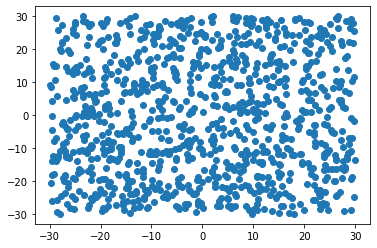

In [3]:
plt.scatter(x[:,0],x[:,1])

In [4]:
theta = jnp.array([[2.0,-1.0]]).T
theta 

DeviceArray([[ 2.],
             [-1.]], dtype=float32)

In [5]:
bern = tfd.Bernoulli(x@theta)

In [9]:
y = bern.sample(sample_shape=1,seed=key)
y.shape

(1, 1000, 1)

In [10]:
bern.log_prob(y)[0,:,0]

DeviceArray([-2.20206182e-08, -3.83840587e-25, -1.57671585e-32,
             -1.98238870e-09, -1.91096063e-11, -2.12475978e-04,
             -5.32647570e-18, -7.78290778e-05, -1.24332236e-18,
             -6.02809784e-32, -8.18867786e-23, -3.98708925e-13,
             -5.13072386e-14, -1.85268213e-15, -1.80531934e-01,
             -1.13699873e-21, -1.44085826e-21, -9.07106460e-06,
             -2.48633837e-03, -1.42138424e-06, -1.31427363e-24,
             -1.09715792e-09, -1.48275610e-36, -6.03192078e-23,
             -1.72947868e-32, -2.71485231e-22, -2.35043583e-03,
             -2.49052849e-02, -5.86045206e-01, -1.08748931e-19,
             -1.09209248e-17, -2.29479978e-03, -2.07810779e-13,
             -2.19463126e-31, -1.27887863e-14, -1.39236427e-05,
             -1.81597490e-15, -7.36099558e-33, -4.39141444e-32,
             -1.36354483e-10, -5.81945177e-18, -1.60791801e-17,
             -5.08477349e-09, -2.03936667e-14, -2.41882455e-15,
             -3.80627934e-20, -8.9849826

In [11]:
jnp.sum(y[:]==1)

DeviceArray(488, dtype=int32)

In [12]:
one = y[:]==1


In [13]:
x.shape

(1000, 2)

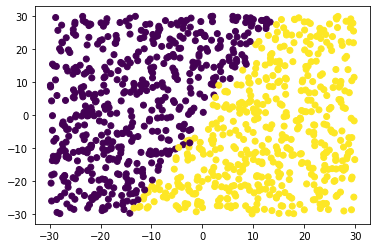

In [14]:
# plt.scatter(x[one][:,0],x[one][:,1])
# plt.scatter(x[~one][:,0],x[~one][:,1],c='r')
plt.scatter(x[:,0],x[:,1],c=y)
plt.savefig("")

In [16]:
prior_mean = jnp.array([1.9,5.9])
prior_var = 5*jnp.identity(2)
prior_normal = tfd.MultivariateNormalFullCovariance(
    loc= prior_mean,covariance_matrix=prior_var
)


In [18]:
import pickle
dictionary = {
    "data":{"x":x,"y":y},
    'prior':{'loc':prior_mean,'covariance_matrix':prior_var}
    }
with open("coin_toss_data",'wb') as f:
    pickle.dump(dictionary,f)

In [233]:
y.reshape((1, m, 1))
def log_postfn(theta):
    log_prior = prior_normal.log_prob(theta)
    logit = (x@theta.reshape(n,1))
    likelihood_bern = tfd.Bernoulli(logit)
    log_like = jnp.sum(likelihood_bern.log_prob(y)[0,:,0])
    return (log_like+log_prior)
log_postfn(jnp.array([10.4, 11.4]))



DeviceArray(-72710.35, dtype=float32)

In [234]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [235]:
rmh = blackjax.rmh(log_postfn, sigma=jnp.identity(n) * 0.8)
initial = jnp.array(jnp.array([12,1.0]))
initial_state = rmh.init(initial)
initial_state

RMHState(position=DeviceArray([12.,  1.], dtype=float32), log_probability=DeviceArray(-12033.867, dtype=float32))

In [236]:
rng_key = jax.random.PRNGKey(0)
_, rng_key = jax.random.split(rng_key)
states = inference_loop(rng_key, rmh.step, initial_state, 10000)

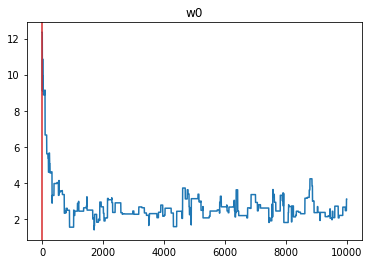

In [237]:
burnin = 0
fig, ax = plt.subplots()
ax.plot(states.position[:,0])
ax.set_title(f"w0")
ax.axvline(x=burnin, c="tab:red")
plt.show()

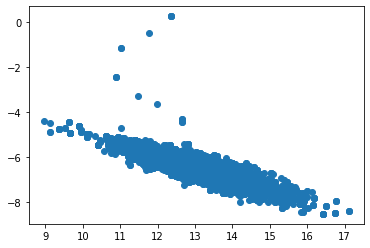

In [210]:
plt.scatter(states.position[burnin:,0],states.position[burnin:,1])

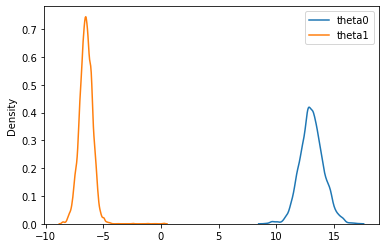

In [211]:
sns.kdeplot(states.position[burnin:,0],label="theta0")
sns.kdeplot(states.position[burnin:,1],label="theta1")
plt.legend()
plt.show()